In [124]:
#импортируем библиотеки
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization,Activation,Dropout
from matplotlib import pyplot as plt
from datawig import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (9,9)

In [125]:
#загружаем данные
Data = pd.read_csv('WISDM_ar_v1.1_raw.txt', names= ["user-id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
Data["z-axis"] = [float(str(Element).replace(";", "")) for Element in Data["z-axis"]]
Data.dropna(axis=0,inplace=True)
#Data = Data.iloc[np.random.permutation(len(Data))]

In [126]:
#переименуем столбец для удобства
Data.rename(columns={'user-id':'user'},inplace=True)

## Посмотрим на первых двух пользователей

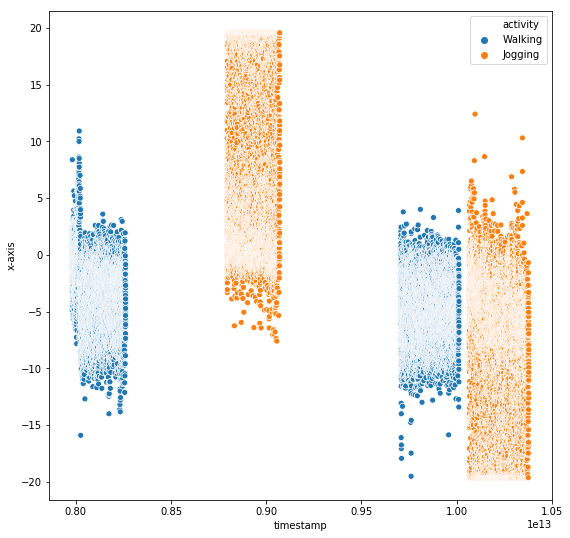

In [127]:
sns.scatterplot(x='timestamp',y='x-axis',hue='activity',data=Data[Data.user==2])
plt.show()

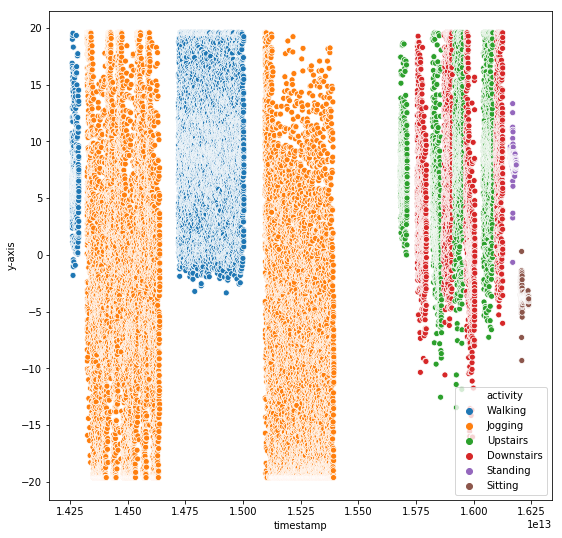

In [128]:
sns.scatterplot(x='timestamp',y='y-axis',hue='activity',data=Data[Data.user==24])
plt.show()

## Разделим данные на тест и тренировочные и произведем обучение на одном user=1


In [129]:
Data_1=Data[Data.user==1]
Data_1=shuffle(Data_1)
Y=Data_1.activity
Data_1.drop(columns=['activity'],axis=1,inplace=True)
X=Data_1
X_train1, X_test1, Y_train1, Y_test1 =train_test_split(X, Y, test_size=0.33, random_state=42)
Y_train_one=Y_train1
Y_train1=pd.get_dummies(Y_train1)
Y_test1=pd.get_dummies(Y_test1)

X_train1=X_train1.astype('float')
X_test1=X_test1.astype('float')
#Y_test1.size
Y_train1.head()
Y_test1.head()



Downstairs  Jogging  Upstairs  Walking
954971           0        0         0        1
947851           0        0         0        1
945952           0        0         0        1
955950           0        0         0        1
951586           0        1         0        0

## Функция, создающая лес

In [130]:
def forest(k,X_train,Y_train,X_test,Y_test):
    forest_model = RandomForestRegressor(random_state=1)
    forest_model.fit(X_train.iloc[:k], Y_train.iloc[:k])
    melb_preds = forest_model.predict(X_test)
    return mean_absolute_error(Y_test, melb_preds)

## Не анализируя природу данных попробуем создать модель и обучить ее на тех признаках, которые мы имеем

In [131]:
print(forest(10000,X_train1,Y_train1,X_test1,Y_test1))


0.0007328414030122298


## Как видим, модель ведет себя очень странно, даже если бы она просто угадывала, то мы бы получили больший процент

## Рассмотрим еще один, предположительно более хороший метод обучения

In [132]:
Y_train_two=Y_train1.iloc[:,0]*4+Y_train1.iloc[:,1]*3+Y_train1.iloc[:,2]*2+Y_train1.iloc[:,3]*1
Y_test_two=Y_test1.iloc[:,0]*4+Y_test1.iloc[:,1]*3+Y_test1.iloc[:,2]*2+Y_test1.iloc[:,3]*1



In [133]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train1, Y_train_two, verbose=False)
predictions = my_model.predict(X_test1)
print (predictions)

[1.0107738 1.0063696 1.0063696 ... 1.0063696 2.0447078 3.9621372]


In [134]:
def accuracy(prediction, answer):
    i = 0.
    for x, y in zip(prediction, answer):
        if(int(x) == y):
            i += 1
    return i / (len(answer))

In [135]:
accuracy(predictions,Y_test_two)

0.6185181441423229

## Ого, такая точность нас уже устраивает больше, но давайте попробуем все-таки разобраться в природе данных

In [136]:
d=Data[Data.user==1][Data.activity=='Jogging'].describe()
d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


user     timestamp        x-axis        y-axis        z-axis
count  11056.0  1.105600e+04  11056.000000  11056.000000  11056.000000
mean       1.0  5.854319e+12     -0.208456      0.197931      1.164557
std        0.0  3.322621e+11     10.706282      9.483499      5.653878
min        1.0  5.374662e+12    -19.610000    -19.610000    -17.200000
25%        1.0  5.512840e+12     -7.080000     -6.430000     -2.530000
50%        1.0  6.022097e+12     -0.040000      0.420000      0.570000
75%        1.0  6.160305e+12      6.827500      6.400000      4.860000
max        1.0  6.298492e+12     19.570000     19.570000     19.000000

In [137]:
a=np.array([d.iloc[1,2] for i in range(0,len(Data[Data.user==1][Data.activity=='Jogging']))])
Data.dtypes
a.dtype

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


dtype('float64')

In [139]:
#d=Data[Data.user==][Data.activity==j]

## Пока остановился на этом, в дальнейшем хочу сгенепиповать новые признаки

In [140]:
Date=pd.DataFrame(columns=['mean_x','mean_y','mean_z','std_x','std_y','std_z'])

for i in range(1,2):
    for j in tuple(['Walking', 'Downstairs', 'Sitting', 'Upstairs', 'Jogging', 'Standing']):
        d=Data[Data.user==i][Data.activity==j]
        d1=Data[Data.user==i][Data.activity==j].describe()
        mean_x=np.array([d1.iloc[1,2] for i in range(0,len(d))])
        mean_y=np.array([d1.iloc[1,3] for i in range(0,len(d))])
        mean_z=np.array([d1.iloc[1,4] for i in range(0,len(d))])
        std_x=np.array([d1.iloc[2,2] for i in range(0,len(d))])
        std_y=np.array([d1.iloc[2,3] for i in range(0,len(d))])
        std_z=np.array([d1.iloc[2,4] for i in range(0,len(d))])
        dat=pd.DataFrame({'mean_x':mean_x,'mean_y':mean_y,'mean_z':mean_z})
        dat_std=pd.DataFrame({'std_x':std_x,'std_y':std_y,'std_z':std_z})
        
        print(dat.head())
        print(dat_std.head())
        do=dat.join(dat_std)
        pd.concat([Date,do])
        print(Date.tail())
    
        


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


     mean_x    mean_y    mean_z
0 -1.000041  9.455536 -0.343607
1 -1.000041  9.455536 -0.343607
2 -1.000041  9.455536 -0.343607
3 -1.000041  9.455536 -0.343607
4 -1.000041  9.455536 -0.343607
      std_x    std_y     std_z
0  6.967989  5.39616  3.220753
1  6.967989  5.39616  3.220753
2  6.967989  5.39616  3.220753
3  6.967989  5.39616  3.220753
4  6.967989  5.39616  3.220753
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


     mean_x   mean_y    mean_z
0 -1.033366  8.54287  0.575641
1 -1.033366  8.54287  0.575641
2 -1.033366  8.54287  0.575641
3 -1.033366  8.54287  0.575641
4 -1.033366  8.54287  0.575641
      std_x     std_y     std_z
0  8.061251  4.761467  3.978546
1  8.061251  4.761467  3.978546
2  8.061251  4.761467  3.978546
3  8.061251  4.761467  3.978546
4  8.061251  4.761467  3.978546
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Empty DataFrame
Columns: [mean_x, mean_y, mean_z]
Index: []
Empty DataFrame
Columns: [std_x, std_y, std_z]
Index: []
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


     mean_x    mean_y   mean_z
0 -6.349433  5.332679  0.63366
1 -6.349433  5.332679  0.63366
2 -6.349433  5.332679  0.63366
3 -6.349433  5.332679  0.63366
4 -6.349433  5.332679  0.63366
      std_x     std_y    std_z
0  7.779192  6.492359  4.75123
1  7.779192  6.492359  4.75123
2  7.779192  6.492359  4.75123
3  7.779192  6.492359  4.75123
4  7.779192  6.492359  4.75123
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


     mean_x    mean_y    mean_z
0 -0.208456  0.197931  1.164557
1 -0.208456  0.197931  1.164557
2 -0.208456  0.197931  1.164557
3 -0.208456  0.197931  1.164557
4 -0.208456  0.197931  1.164557
       std_x     std_y     std_z
0  10.706282  9.483499  5.653878
1  10.706282  9.483499  5.653878
2  10.706282  9.483499  5.653878
3  10.706282  9.483499  5.653878
4  10.706282  9.483499  5.653878
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []
Empty DataFrame
Columns: [mean_x, mean_y, mean_z]
Index: []
Empty DataFrame
Columns: [std_x, std_y, std_z]
Index: []
Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [141]:
Date

Empty DataFrame
Columns: [mean_x, mean_y, mean_z, std_x, std_y, std_z]
Index: []

In [153]:
a=pd.DataFrame({'a':[1,2],'b':[55,5]})
b=pd.DataFrame({'c':[6,2],'d':[7,57]})
c=pd.concat([a,b],axis=0)

c.head()

a     b    c     d
0  1.0  55.0  NaN   NaN
1  2.0   5.0  NaN   NaN
0  NaN   NaN  6.0   7.0
1  NaN   NaN  2.0  57.0